In [1]:
%pip install databricks
%pip install koalas
%pip install joblibspark

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import databricks.koalas as ks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import nltk 
from nltk.corpus import stopwords
nltk.download('punkt')
import seaborn as sns
import glob
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
import pickle
plt.savefig("mulit_plot.jpg")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


<Figure size 432x288 with 0 Axes>

In [3]:
import findspark as fs
fs.init()

In [4]:
wine_dataset_1 = ks.read_json("/data/winemag-data-130k-v2.json")
wine_dataset_2 = ks.read_csv("/data/winemag-data_first150k.csv")
wine_dataset_2 = wine_dataset_2.spark.repartition(7)
wine_dataset_1 = wine_dataset_1.spark.repartition(7)
selected_columns =['points','description','price','designation','variety','region_1','region_2','province','country','winery']
set_with_columns_1 = wine_dataset_1[selected_columns]
set_with_columns_2 = wine_dataset_2[selected_columns]

In [5]:
all_raw_data = set_with_columns_1.append(set_with_columns_2, ignore_index=True)
all_raw_data.head()

,points,description,price,designation,variety,region_1,region_2,province,country,winery
0,85,This wood-aged wine shows dark berry fruits an...,10,Cabra Cega,Portuguese Red,None,None,Lisboa,Portugal,Casa Santos Lima
1,88,A flintiness mixes with lemon peel in this ful...,30,Home Ranch,Chardonnay,Dry Creek Valley,Sonoma,California,US,Sbragia
2,91,Golden color and hints of oatmeal on the nose ...,50,Three Graces,Sparkling Blend,None,None,England,England,Chapel Down
3,90,While bold and rich with a concentrated black ...,38,None,Plavac Mali,None,None,Peljesac,Croatia,Korta Katarina
4,92,This five-grape blend is muscular and wide on ...,28,Finca Malaveïna,Red Blend,Empordà,None,Northern Spain,Spain,Perelada


In [6]:
def read_words_from_file(filename):
    file = ks.read_csv(filename,comment=';',names=["word"],header=None)
    return file

In [7]:
positive_words = read_words_from_file("/data/positive-words.txt")
negative_words = read_words_from_file("/data/negative-words.txt")
positive_words_DF = positive_words
negative_words_DF = negative_words

# Profliowanie danych
## Podsumowanie pozytywnych i negatywnych słów

In [8]:
import pandas as pd
neg_desc = negative_words_DF.to_pandas()
pos_desc = positive_words_DF.to_pandas()
describe_words = pd.concat([neg_desc.describe(), pos_desc.describe()], axis=1)
describe_words.columns =["negative_words", "positive_words"]
describe_words

,negative_words,positive_words
count,4783,2006
unique,4783,2006
top,manipulate,flatteringly
freq,1,1


## Analiza danych numerycznych

In [9]:
# # Dane w zapisna edo CSV w celu użycia jako cache
# profiled_data = all_raw_data.copy()
# profiled_data["number_of_tokens_in_description"] = profiled_data.apply(lambda row: len(nltk.word_tokenize(row['description'])), axis=1)
# profiled_data.to_csv("profiled_cache_data.csv")

In [10]:
#profiled_data = pd.read_csv("profiled_cache_data.csv", header=0,index_col=0)

In [11]:
profiled_data = all_raw_data
profiled_data.head()

,points,description,price,designation,variety,region_1,region_2,province,country,winery
0,85,This wood-aged wine shows dark berry fruits an...,10,Cabra Cega,Portuguese Red,None,None,Lisboa,Portugal,Casa Santos Lima
1,88,A flintiness mixes with lemon peel in this ful...,30,Home Ranch,Chardonnay,Dry Creek Valley,Sonoma,California,US,Sbragia
2,91,Golden color and hints of oatmeal on the nose ...,50,Three Graces,Sparkling Blend,None,None,England,England,Chapel Down
3,90,While bold and rich with a concentrated black ...,38,None,Plavac Mali,None,None,Peljesac,Croatia,Korta Katarina
4,92,This five-grape blend is muscular and wide on ...,28,Finca Malaveïna,Red Blend,Empordà,None,Northern Spain,Spain,Perelada


In [111]:
profiled_data = all_raw_data_copy
profiled_data["price"] = profiled_data["price"].astype('float32')
profiled_data["points"] = profiled_data["points"].astype('float32')

profiled_data[["points", "price"]].describe()

,points,price
count,143660.00000,143670.000000
mean,88.48990,35.148765
std,3.04378,37.646738
min,80.00000,4.000000
25%,86.00000,18.000000
50%,88.00000,30.000000
75%,91.00000,39.000000
max,100.00000,3300.000000


In [13]:
profiled_data = all_raw_data
uniques = []
analized_columns = ["designation", "variety", "region_1", "region_2", "province", "country", "winery"]

In [14]:
# Tablica z unikalnymi wartościami dla poszczególnych kolumn
uniques = [profiled_data[x].unique() for x in analized_columns]
# Tablica z ilością tych wartości
uniques_len = [len(x) for x in uniques]

In [15]:
ks.DataFrame(data={"unique_count":uniques_len},index=analized_columns).sort_values(by=["unique_count"], ascending=False)

,unique_count
designation,47263
winery,19205
region_1,1355
variety,781
province,515
country,56
region_2,45


# Czestość występowania wartości w zbiorze
Dane potrzebne do uzyskania poniższych wyników, zostały przygotowane za pomocą transformacji na danych wykonanych w pythonie oraz w wyniku odpalenia WordCount-a dla MapReduce.
Transformacje te dostepne sa w pliku data_manipulation

## Sprawdzenie najczęściej występujących słów w opisach 
Dla zbioru pozbawionego "stop words" oraz znaków interpunkcyjnych

In [17]:
description_words_DF = ks.read_csv("/data/description_words.csv", index_col=None, header=0)

In [18]:
description_words_DF.columns

Index(['description_words', 'count'], dtype='object')

<AxesSubplot:xlabel='count', ylabel='description_words'>

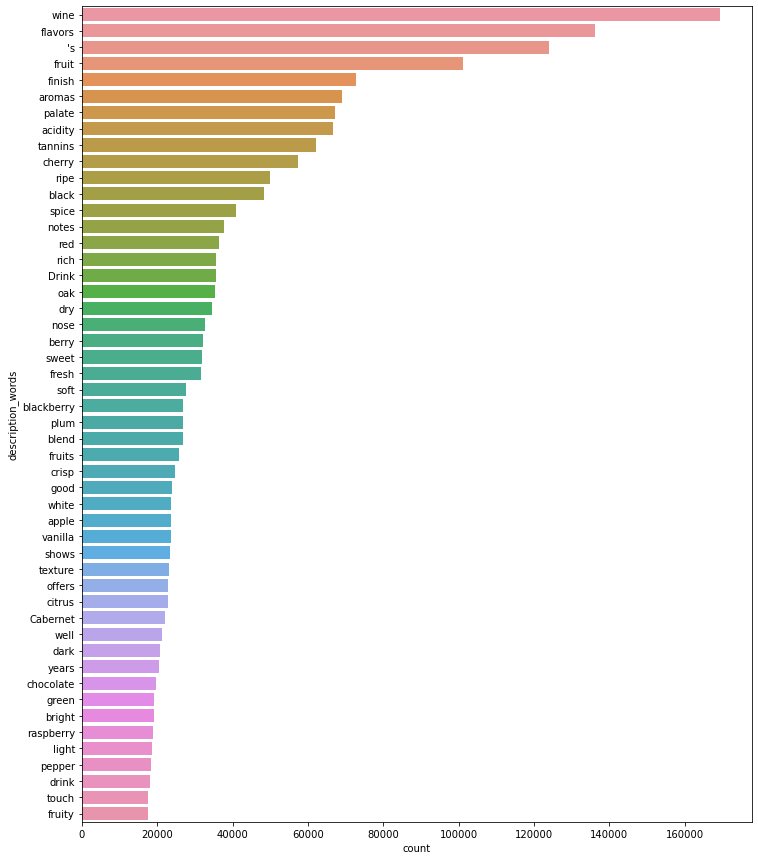

In [93]:
description_words_DF_pandas = description_words_DF[:100].to_pandas()
fig, ax = plt.subplots(figsize=(12, 15))
sns.barplot(x="count", y="description_words", data=description_words_DF_pandas.head(50),
            label="Most pupular words")

## Sprawdzenie najczęsciej wysstępujących wartości dla wybranych kolumn
### Wczytanie plików po policzeniu czestości występowania słów

In [20]:

country_popular_DF = ks.read_csv("/data/country.csv", index_col=None, header=0).fillna(0)
province_DF = ks.read_csv("/data/province.csv", index_col=None, header=0).fillna(0)
region_1_DF = ks.read_csv("/data/region_1.csv", index_col=None, header=0).fillna(0)
region_2_DF = ks.read_csv("/data/region_2.csv", index_col=None, header=0).fillna(0)

variety_DF = ks.read_csv("/data/variety.csv", index_col=None, header=0).fillna(0)
winery_DF = ks.read_csv("/data/winery.csv", index_col=None, header=0).fillna(0)
designation_DF = ks.read_csv("/data/designation.csv", index_col=None, header=0).fillna(0)


In [97]:
province_DF2 = province_DF[:100].to_pandas()
region_1_DF2 = region_1_DF[:100].to_pandas()
region_2_DF2 = region_2_DF[:100].to_pandas()
variety_DF2 = variety_DF[:100].to_pandas()
winery_DF2 = winery_DF[:100].to_pandas()
designation_DF2 = designation_DF[:100].to_pandas()
country_popular_DF2 = country_popular_DF[:100].to_pandas()

In [96]:
designation_DF2.head(5)

,designation,count
0,0,83200
1,Reserve,4761
2,Reserva,3069
3,Estate,2893
4,Barrel sample,1701


In [98]:
designation_DF2["count"]= designation_DF2["count"].head(20).astype('float32')
variety_DF2["count"]= variety_DF2["count"].head(20).astype('float32')
winery_DF2["count"]= winery_DF2["count"].head(20).astype('float32')

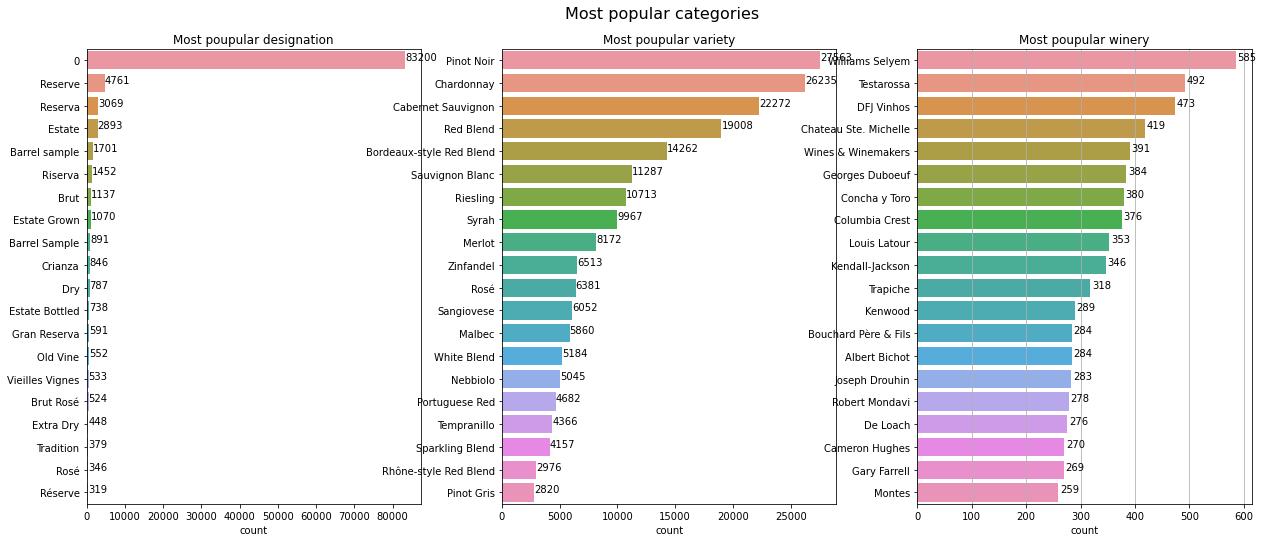

In [99]:
fig, ax = plt.subplots(1,3,figsize=(18,8 ) )
fig.tight_layout(pad=5.0)
plt.grid(True)
fig.suptitle("Most popular categories", fontsize=16)

ax[0].title.set_text('Most poupular designation')
sns.barplot(ax=ax[0], x="count", y="designation", data=designation_DF2.head(20))

ax[1].title.set_text('Most poupular variety')
sns.barplot(ax=ax[1], x="count", y="variety", data=variety_DF2.head(20))

ax[2].title.set_text('Most poupular winery')
sns.barplot(ax=ax[2], x="count", y="winery", data=winery_DF2.head(20))


for a in ax:
    a.set_ylabel('') 
    for p in a.patches:
        height = p.get_height() # height of each horizontal bar is the same
        width = p.get_width() # width (average number of passengers)
        # adding text to each bar
        a.text(x = width+3, # x-coordinate position of data label, padded 3 to right of bar
        y = p.get_y()+(height/3), # # y-coordinate position of data label, padded to be in the middle of the bar
        s = "{:.0f}".format(width), # data label, formatted to ignore decimals
        va = "center") # sets vertical alignment (va) to center



In [100]:
country_popular_DF2["count"]= country_popular_DF2["count"].head(20).astype('float32')
province_DF2["count"]= province_DF2["count"].head(20).astype('float32')
region_1_DF2["count"]= region_1_DF2["count"].head(20).astype('float32')
region_2_DF2["count"]= region_2_DF2["count"].head(20).astype('float32')

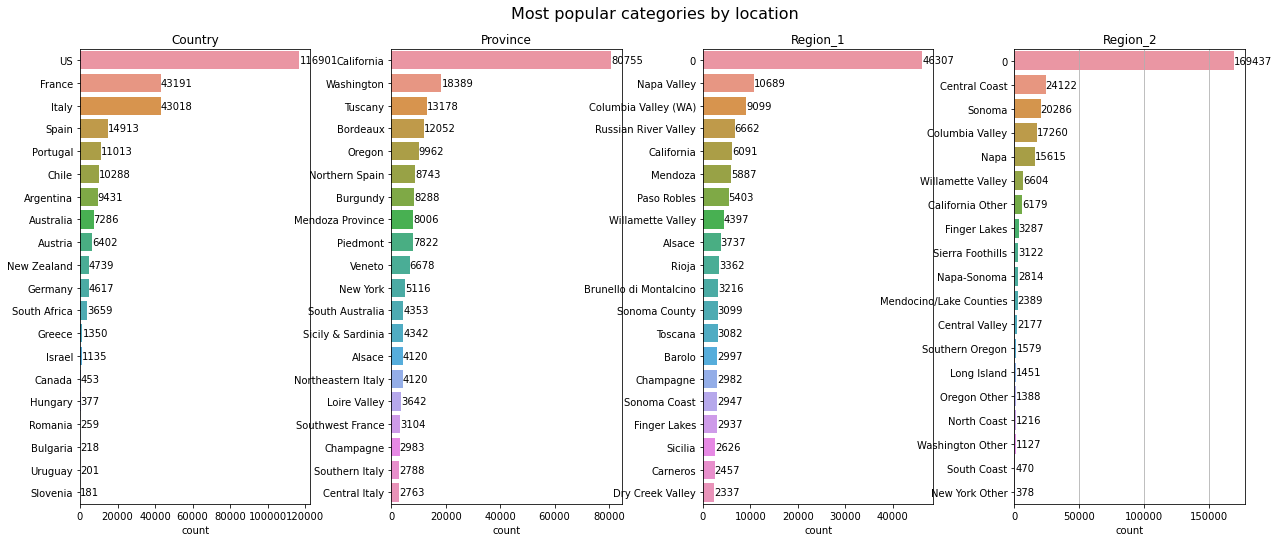

In [101]:
fig, ax = plt.subplots(1,4,figsize=(18,8 ) )
fig.tight_layout(pad=5.0)
plt.grid()

fig.suptitle("Most popular categories by location", fontsize=16)

ax[0].title.set_text('Country')
sns.barplot(ax=ax[0],x="count", y="Country", data=country_popular_DF2.head(20))

ax[1].title.set_text('Province')
sns.barplot(ax=ax[1],x="count", y="province", data=province_DF2.head(20))

ax[2].title.set_text('Region_1')
sns.barplot(ax=ax[2], x="count", y="region_1", data=region_1_DF2.head(20))

ax[3].title.set_text('Region_2')
sns.barplot(ax=ax[3], x="count", y="region_2", data=region_2_DF2.head(20))


for a in ax:
    a.set_ylabel('') 
    for p in a.patches:
        height = p.get_height() # height of each horizontal bar is the same
        width = p.get_width() # width (average number of passengers)
        # adding text to each bar
        a.text(x = width+3, # x-coordinate position of data label, padded 3 to right of bar
        y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
        s = "{:.0f}".format(width), # data label, formatted to ignore decimals
        va = "center") # sets vertical alignment (va) to center


# Rozkład ocen
Policznie rozkładu

In [27]:
profiled_data3 = all_raw_data.copy()
points_DF = profiled_data3.copy().drop(["description","price", "designation","variety","region_1","region_2","province","country","winery","number_of_tokens_in_description"], axis=1)
print(type(points_DF))

<class 'databricks.koalas.frame.DataFrame'>


In [28]:
scala_points_DF = points_DF.to_spark()

In [29]:
scala_points_DF = scala_points_DF.filter(scala_points_DF["points"].rlike("^[0-9]*$"))

In [30]:
koalas_points_DF = scala_points_DF.to_koalas()

In [31]:
points_DF5 = koalas_points_DF.groupby("points").agg(count=ks.NamedAgg(column='points',aggfunc='count'))

In [32]:
points_DF5 = points_DF5.reset_index()
points_DF5.head(20)

,points,count
0,87,37676
1,85,21939
2,98,208
3,99,83
4,96,1218
5,100,43
6,89,25144
7,90,31380
8,95,3250
9,93,12501


<AxesSubplot:ylabel='Frequency'>

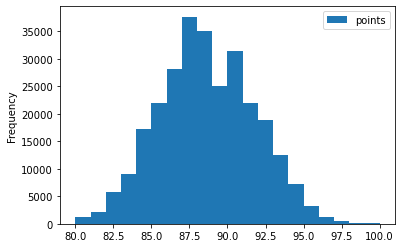

In [33]:
koalas_points_DF["points"] = koalas_points_DF["points"].astype("int32")
koalas_points_DF.hist(bins=20)

# Algorytm 
1. (P-N)/W

In [34]:
# Funkcja obliczające współczynnik 
def description_to_normalize(all_data,pos,neg):
    new_data = []
    all_data["desc_value"] = "0"
    for index2,row in all_data.iterrows():
        print("1")
        desc = row["description"]
        desc = desc.replace(",","").replace(";","").replace(":","").replace(".","").replace("!","").replace("?","")
        desc = desc.lower()
        desc = desc.split(" ")
        n_pos = 0
        n_neg = 0
        for i in desc:
            if i in pos["word"].values:
                n_pos+=1
            elif i in neg["word"].values:
                n_neg+=1
        value = (n_pos-n_neg)/len(desc)
        new_data.append(value)
    return(new_data)

In [35]:
# pd.options.mode.chained_assignment = None
# all_data_transformed= description_to_normalize(all_raw_data,positive_words_DF,negative_words_DF)
#all_data_transformed2 = all_data_transformed.copy()
all_raw_data_copy = all_raw_data.copy()

In [36]:
# all_data_transformed["desc_value"]=(all_data_transformed["desc_value"]-all_data_transformed["desc_value"].min())/(all_data_transformed["desc_value"].max()-all_data_transformed["desc_value"].min())
all_raw_data_copy = all_raw_data_copy.drop(['description',"designation","region_1","region_2","winery","desc_value"],axis='columns')

## Przygotowanie danych

In [37]:
all_raw_data_copy["price"].fillna(int(all_raw_data_copy["price"].mean()),inplace = True)

In [38]:
#all_raw_data_copy["price"] = all_raw_data_copy["price"].astype("int32")

In [39]:
all_raw_data_copy.head()

,points,price,variety,province,country
0,88,28,Viognier,California,US
1,88,28,Viognier,California,US
2,94,34,Bordeaux-style Red Blend,Bordeaux,France
3,94,34,Bordeaux-style Red Blend,Bordeaux,France
4,94,34,Bordeaux-style Red Blend,Bordeaux,France


In [105]:
scala_points_DF_copy = all_raw_data_copy.to_spark()
all_raw_data_copy = scala_points_DF_copy.filter(scala_points_DF_copy["price"].rlike("^[0-9]*$"))

In [106]:
all_raw_data_copy = all_raw_data_copy.to_koalas()

In [42]:
one_raw_data = all_raw_data_copy["variety"]
one_raw_data_group = one_raw_data.unique()
data_raw_data_group = ks.DataFrame(data=one_raw_data_group)
data_raw_data_group = data_raw_data_group.sort_values(by='variety', ascending=True)
data_raw_data_group = data_raw_data_group.reset_index()
data_raw_data_group.head()

,index,variety
0,311,Abouriou
1,29,Agiorgitiko
2,455,Aglianico
3,123,Aidani
4,323,Airen


In [43]:
all_raw_data_copy_spark = all_raw_data_copy.to_spark()
data_raw_data_group_spark = data_raw_data_group.to_spark()
all_raw_data_copy_spark = all_raw_data_copy_spark.join(data_raw_data_group_spark,all_raw_data_copy_spark["variety"] == data_raw_data_group_spark["variety"])
all_raw_data_copy_spark.head()

Row(points='89', price='18', variety='Duras', province='Southwest France', country='France', index=0, variety='Duras')

In [44]:
all_raw_data_copy_spark_drop = all_raw_data_copy_spark.drop("variety")
all_raw_data_copy_spark_drop.head()

Row(points='88', price='28', province='California', country='US', index=52)

In [45]:
all_raw_data_copy_spark_drop_koalas = all_raw_data_copy_spark_drop.to_koalas()

In [46]:
one_raw_data_province = all_raw_data_copy_spark_drop_koalas["province"]
one_raw_data_province = one_raw_data_province.unique()
one_raw_data_province_group = ks.DataFrame(data=one_raw_data_province)
one_raw_data_province_group = one_raw_data_province_group.sort_values(by='province', ascending=True)
one_raw_data_province_group = one_raw_data_province_group.reset_index()
one_raw_data_province_group.head()

,index,province
0,261,60.0
1,311,82
2,18,87
3,227,Achaia
4,242,Aconcagua Costa


In [47]:
one_raw_data_province_scala = one_raw_data_province_group.to_spark()
one_raw_data_province_scala = one_raw_data_province_scala.filter(one_raw_data_province_scala["province"].rlike("^[a-zA-Z]*$"))
one_raw_data_province_koalas = one_raw_data_province_scala.to_koalas()
one_raw_data_province_koalas.head()

,index,province
0,227,Achaia
1,246,Aegean
2,404,Agioritikos
3,194,Ahr
4,201,Alenquer


In [48]:
one_raw_data_province_koalas = one_raw_data_province_koalas.rename(columns={"index": "index_province"})
one_raw_data_province_koalas.head()

,index_province,province
0,227,Achaia
1,246,Aegean
2,404,Agioritikos
3,194,Ahr
4,201,Alenquer


In [49]:
all_raw_data_copy_spark = all_raw_data_copy_spark_drop
data_raw_data_group_spark = one_raw_data_province_koalas.to_spark()
all_raw_data_copy_spark = all_raw_data_copy_spark.join(data_raw_data_group_spark,all_raw_data_copy_spark["province"] == data_raw_data_group_spark["province"])
all_raw_data_copy_spark.head()

Row(points='90', price='30', province='California', country='US', index=1, index_province=368, province='California')

In [50]:
all_raw_data_copy_spark_drop = all_raw_data_copy_spark.drop("province")
all_raw_data_copy_spark_drop.head()

Row(points='90', price='30', country='US', index=1, index_province=386)

In [51]:
all_raw_data_copy_spark_drop_koalas = all_raw_data_copy_spark_drop.to_koalas()
one_raw_data_country = all_raw_data_copy_spark_drop_koalas["country"]
one_raw_data_country = one_raw_data_country.unique()
one_raw_data_country = ks.DataFrame(data=one_raw_data_country)
one_raw_data_country = one_raw_data_country.sort_values(by='country', ascending=True)
one_raw_data_country = one_raw_data_country.reset_index()
one_raw_data_country.head()

,index,country
0,4,Argentina
1,21,Armenia
2,33,Australia
3,36,Austria
4,30,Bosnia and Herzegovina


In [52]:
one_raw_data_country = one_raw_data_country.rename(columns={"index": "index_country"})
one_raw_data_country.head()

,index_country,country
0,7,Argentina
1,20,Armenia
2,33,Australia
3,36,Austria
4,29,Bosnia and Herzegovina


In [53]:
all_raw_data_copy_spark = all_raw_data_copy_spark_drop
one_raw_data_country_spark = one_raw_data_country.to_spark()
all_raw_data_copy_spark = all_raw_data_copy_spark.join(one_raw_data_country_spark,all_raw_data_copy_spark["country"] == one_raw_data_country_spark["country"])
all_raw_data_copy_spark.head()

Row(points='88', price='34', country='South Africa', index=0, index_province=347, index_country=39, country='South Africa')

In [54]:
all_raw_data_copy_spark_drop = all_raw_data_copy_spark.drop("country")
all_raw_data_copy_spark_drop.head()

Row(points='87', price='34', index=186, index_province=248, index_country=0)

In [55]:
all_raw_data_copy_spark_koalas = all_raw_data_copy_spark_drop.to_koalas()
all_raw_data_copy_spark_koalas.head()

,points,price,index,index_province,index_country
0,90,34,182,0,2
1,87,34,182,0,2
2,88,34,182,0,2
3,86,34,182,0,2
4,85,34,182,0,2


In [56]:
#all_raw_data_copy_spark_koalas.to_csv("/data/all_data_transformed.csv")

# Przygotowanie modelu

In [57]:
from sklearn.utils import shuffle
all_data_transformed = all_raw_data_copy_spark_koalas
all_data_transformed = all_data_transformed.sample(frac=1.0).reset_index(drop=True)


all_data_transformed = all_data_transformed.rename(columns={"index": "variety","index_province": "province","index_country": "country"})
all_data_transformed["points"] = all_data_transformed["points"].astype("float32")
all_data_transformed["price"] = all_data_transformed["price"].astype("float32")
all_data_transformed.head()

,points,price,variety,province,country
0,90.0,30.0,1,390,13
1,90.0,38.0,1,390,13
2,86.0,24.0,1,390,13
3,86.0,30.0,1,411,16
4,86.0,24.0,1,141,13


### Zdefiniowanie modelu
Podział danych

In [58]:
spark_all_data_transformed = all_data_transformed.to_spark()

In [59]:
spark_all_data_transformed.columns

['points', 'price', 'variety', 'province', 'country']

In [60]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import GBTRegressor

In [61]:
# Create the feature column using VectorAssembler class
vectorAssembler = VectorAssembler(inputCols =["price", "variety", "province", "country"], outputCol = "points2")
vpp_sdf = vectorAssembler.transform(spark_all_data_transformed)

In [62]:
vpp_sdf.show(2, False)

+------+-----+-------+--------+-------+---------------------+
|points|price|variety|province|country|points2              |
+------+-----+-------+--------+-------+---------------------+
|90.0  |30.0 |1      |390     |13     |[30.0,1.0,390.0,13.0]|
|90.0  |38.0 |1      |390     |13     |[38.0,1.0,390.0,13.0]|
+------+-----+-------+--------+-------+---------------------+
only showing top 2 rows



In [63]:
# Define train and test data split
splits = vpp_sdf.randomSplit([0.7,0.3])
train_df = splits[0]
test_df = splits[1]

### Gradient Boosted trees

In [137]:
# Define the GBT Model
gbt = GBTRegressor(featuresCol="points2", labelCol="points")
gbt_model = gbt.fit(train_df)
gbt_predictions = gbt_model.transform(test_df)

In [138]:
# Evaluate the GBT Model
gbt_evaluator = RegressionEvaluator(labelCol="points", predictionCol="prediction", metricName="mae")
gbt_mae = gbt_evaluator.evaluate(gbt_predictions)
print("The MAE of GBT Tree regression Model is {}".format(gbt_mae))

The MAE of GBT Tree regression Model is 2.049148875560432


In [139]:
kdf_predictions = ks.DataFrame(gbt_predictions)
kdf_predictions.head()

,points,price,variety,province,country,points2,prediction
0,80.0,8.0,425,388,13,"[8.0, 425.0, 388.0, 13.0]",84.545955
1,80.0,9.0,462,376,12,"[9.0, 462.0, 376.0, 12.0]",84.545955
2,80.0,10.0,80,388,13,"[10.0, 80.0, 388.0, 13.0]",84.327335
3,80.0,12.0,294,388,13,"[12.0, 294.0, 388.0, 13.0]",85.534753
4,80.0,13.0,526,369,12,"[13.0, 526.0, 369.0, 12.0]",86.026099


<AxesSubplot:>

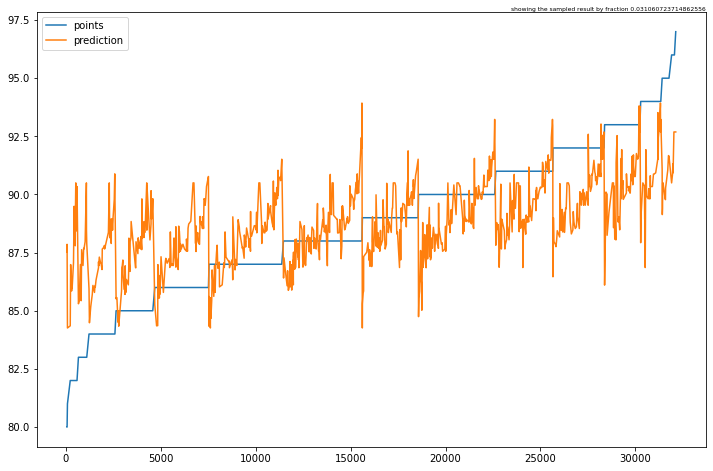

In [67]:
kdf_predictions[['points', 'prediction']].plot(figsize=(12,8))

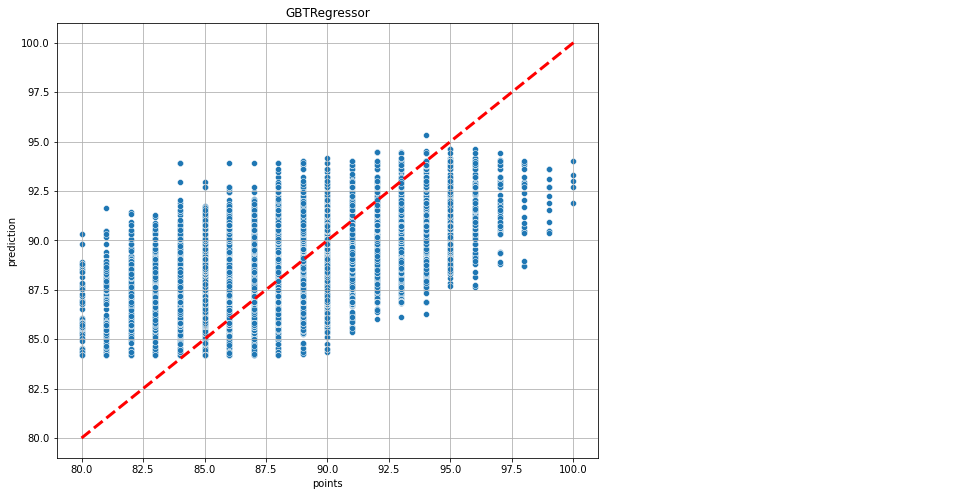

In [68]:
kdf_predictions_pandas = kdf_predictions.to_pandas()
fig, ax = plt.subplots(ncols=2,figsize=(16,8),gridspec_kw=dict(width_ratios=[2,1]))
sns.scatterplot(ax=ax[0],data=kdf_predictions_pandas, x="points", y="prediction")
ax[0].plot([80, 100], [80, 100], 'r--', lw=3)
ax[0].grid(True)
ax[1].axis("off")
ax[0].set_title("GBTRegressor")
plt.show()

### Linear Regression

In [140]:
# Define the licear Model
lr = LinearRegression(featuresCol="points2", labelCol="points")
lr_model = lr.fit(train_df)
lr_predictions = lr_model.transform(test_df)

In [141]:
# Evaluate the LR Model
lr_evaluator = RegressionEvaluator(labelCol="points", predictionCol="prediction", metricName="mae")
lr_rmse = lr_evaluator.evaluate(lr_predictions)
print("The MAE of LR Tree regression Model is {}".format(lr_rmse))

The MAE of LR Tree regression Model is 2.291979039844119


In [71]:
lr_predictions = ks.DataFrame(lr_predictions)
lr_predictions.head()

,points,price,variety,province,country,points2,prediction
0,80.0,6.0,415,374,12,"[6.0, 415.0, 374.0, 12.0]",87.763853
1,80.0,7.0,222,365,12,"[7.0, 222.0, 365.0, 12.0]",87.881998
2,80.0,7.0,250,390,13,"[7.0, 250.0, 390.0, 13.0]",87.835657
3,80.0,7.0,636,390,13,"[7.0, 636.0, 390.0, 13.0]",87.675497
4,80.0,8.0,182,365,12,"[8.0, 182.0, 365.0, 12.0]",87.923772


<AxesSubplot:>

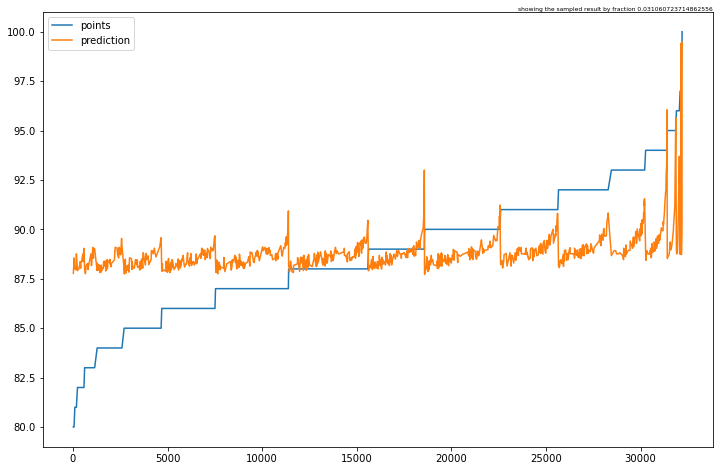

In [72]:
lr_predictions[['points', 'prediction']].plot(figsize=(12,8))

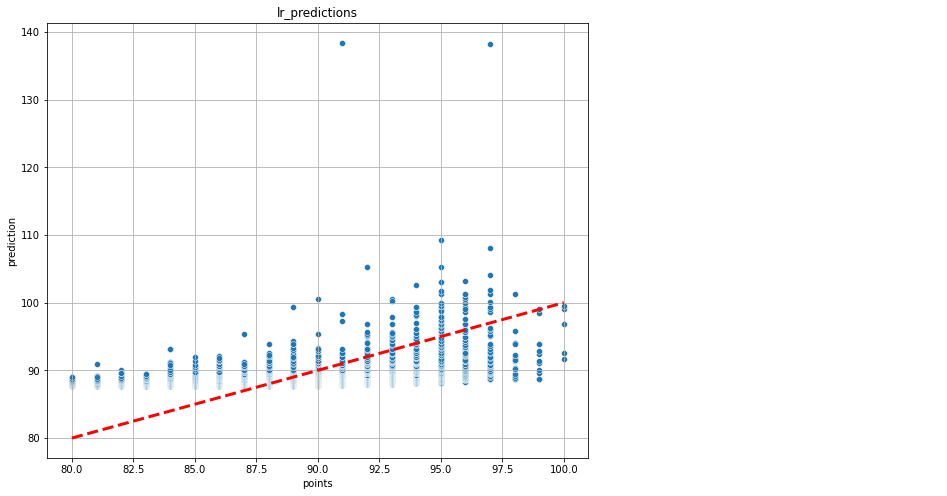

In [73]:
lr_predictions_pandas = lr_predictions.to_pandas()
fig, ax = plt.subplots(ncols=2,figsize=(16,8),gridspec_kw=dict(width_ratios=[2,1]))
sns.scatterplot(ax=ax[0],data=lr_predictions_pandas, x="points", y="prediction")
ax[0].plot([80, 100], [80, 100], 'r--', lw=3)
ax[0].grid(True)
ax[1].axis("off")
ax[0].set_title("lr_predictions")
plt.show()

### Random Forrest

In [142]:
from pyspark.ml.regression import RandomForestRegressor
Glr = RandomForestRegressor(featuresCol="points2", labelCol="points")
Glr_model = Glr.fit(train_df)
Glr_predictions = Glr_model.transform(test_df)

In [143]:
# Evaluate the GLR Model
Glr_evaluator = RegressionEvaluator(labelCol="points", predictionCol="prediction", metricName="mae")
Glr_rmse = Glr_evaluator.evaluate(Glr_predictions)
print("The MAE of GLR Tree regression Model is {}".format(Glr_rmse))

The MAE of GLR Tree regression Model is 2.0209206316216495


In [76]:
Glr_predictions = ks.DataFrame(Glr_predictions)
Glr_predictions.head()

,points,price,variety,province,country,points2,prediction
0,80.0,6.0,434,374,12,"[6.0, 434.0, 374.0, 12.0]",85.334101
1,80.0,7.0,212,44,13,"[7.0, 212.0, 44.0, 13.0]",86.084054
2,80.0,7.0,271,390,13,"[7.0, 271.0, 390.0, 13.0]",85.279949
3,80.0,7.0,655,390,13,"[7.0, 655.0, 390.0, 13.0]",85.402995
4,80.0,8.0,185,365,12,"[8.0, 185.0, 365.0, 12.0]",85.364510


<AxesSubplot:>

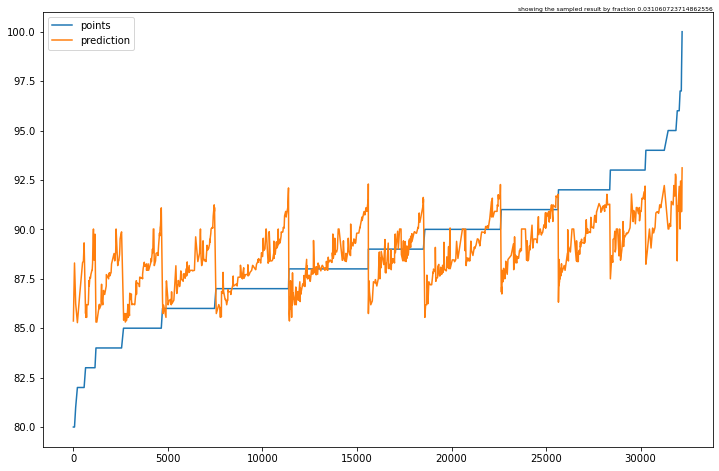

In [77]:
Glr_predictions[['points', 'prediction']].plot(figsize=(12,8))

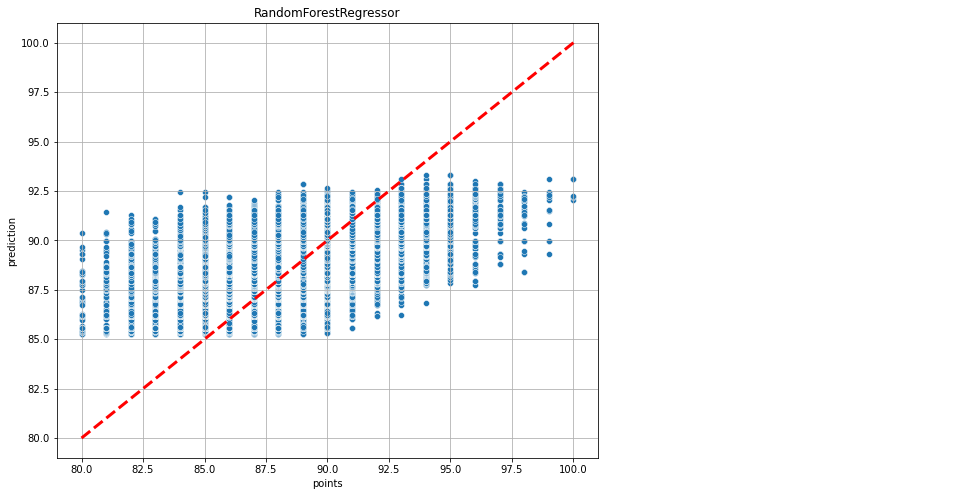

In [78]:
Glr_predictions_pandas = Glr_predictions.to_pandas()
fig, ax = plt.subplots(ncols=2,figsize=(16,8),gridspec_kw=dict(width_ratios=[2,1]))
sns.scatterplot(ax=ax[0],data=Glr_predictions_pandas, x="points", y="prediction")
ax[0].plot([80, 100], [80, 100], 'r--', lw=3)
ax[0].grid(True)
ax[1].axis("off")
ax[0].set_title("RandomForestRegressor")
plt.show()

### Drzewo decyzyjne

In [133]:
from pyspark.ml.regression import DecisionTreeRegressor
Ilr = DecisionTreeRegressor(featuresCol="points2", labelCol="points")
Ilr_model = Ilr.fit(train_df)
Ilr_predictions = Ilr_model.transform(test_df)

Exception ignored in: <function JavaWrapper.__del__ at 0x7ff1c58ae790>
Traceback (most recent call last):
  File "/usr/lib/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RegressionEvaluator' object has no attribute '_java_obj'


In [136]:
# Evaluate the GLR Model
Ilr_evaluator = RegressionEvaluator(labelCol="points", predictionCol="prediction", metricName="mae")
Ilr_mae = Ilr_evaluator.evaluate(Ilr_predictions)
print("The MAE of GLR Tree regression Model is {}".format(Ilr_mae))

The MAE of GLR Tree regression Model is 2.0388189305756255


In [81]:
Ilr_predictions = ks.DataFrame(Ilr_predictions)
Ilr_predictions.head()

,points,price,variety,province,country,points2,prediction
0,80.0,6.0,412,383,12,"[6.0, 412.0, 383.0, 12.0]",85.382914
1,80.0,7.0,212,42,13,"[7.0, 212.0, 42.0, 13.0]",85.382914
2,80.0,7.0,250,385,13,"[7.0, 250.0, 385.0, 13.0]",85.382914
3,80.0,7.0,636,385,13,"[7.0, 636.0, 385.0, 13.0]",85.382914
4,80.0,8.0,185,356,12,"[8.0, 185.0, 356.0, 12.0]",85.382914


<AxesSubplot:>

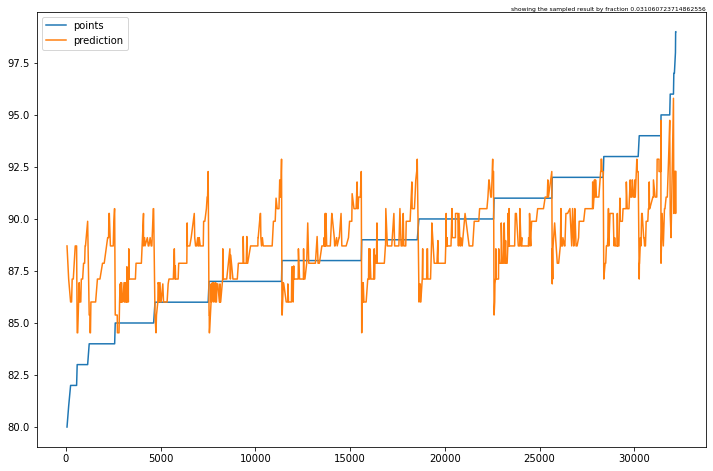

In [82]:
Ilr_predictions[['points', 'prediction']].plot(figsize=(12,8))

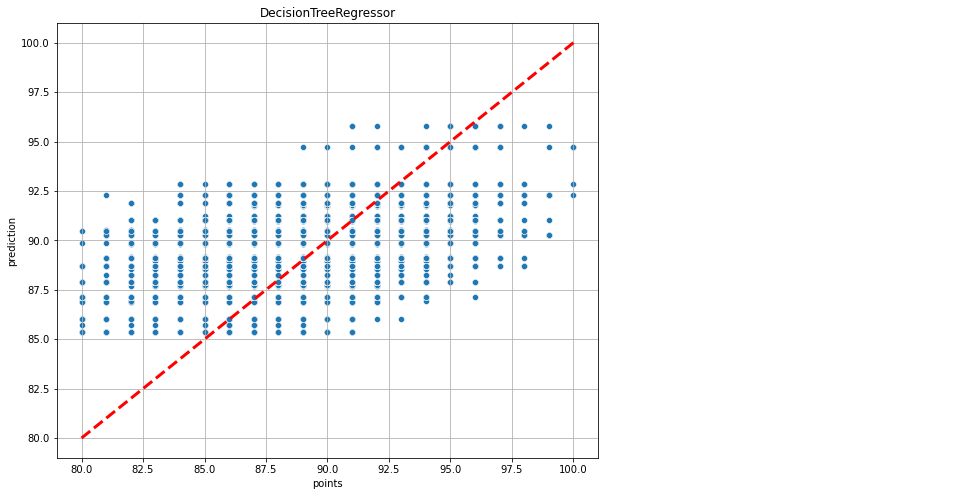

In [83]:
Ilr_predictions_pandas = Ilr_predictions.to_pandas()
fig, ax = plt.subplots(ncols=2,figsize=(16,8),gridspec_kw=dict(width_ratios=[2,1]))
sns.scatterplot(ax=ax[0],data=Ilr_predictions_pandas, x="points", y="prediction")
ax[0].plot([80, 100], [80, 100], 'r--', lw=3)
ax[0].grid(True)
ax[1].axis("off")
ax[0].set_title("DecisionTreeRegressor")
plt.show()

### Extra Trees

In [84]:
model = ExtraTreesRegressor()
ExtraTreesRegressor(n_jobs=-1)

ExtraTreesRegressor(n_jobs=-1)

In [85]:
train_df2= train_df.to_koalas()
test_df2= test_df.to_koalas()

In [86]:
train_df2 = train_df2.to_pandas()
test_df2= test_df2.to_pandas()

In [87]:
train_df2.head(5)

,points,price,variety,province,country,points2
0,80.0,7.0,204,356,12,"[7.0, 204.0, 356.0, 12.0]"
1,80.0,7.0,460,383,12,"[7.0, 460.0, 383.0, 12.0]"
2,80.0,7.0,574,118,4,"[7.0, 574.0, 118.0, 4.0]"
3,80.0,8.0,521,385,13,"[8.0, 521.0, 385.0, 13.0]"
4,80.0,9.0,249,356,12,"[9.0, 249.0, 356.0, 12.0]"


In [118]:
from sklearn.utils import parallel_backend
from joblibspark import register_spark

In [119]:
register_spark()

In [88]:
model.fit(train_df2[["price","variety","province","country"]],train_df2["points"])


In [125]:
with parallel_backend('spark', n_jobs=4):
    y_pred = model.predict(test_df2[["price","variety","province","country"]])

In [128]:
mae = round(metrics.mean_absolute_error(test_df2["points"], y_pred),3)
rmse = round(metrics.mean_squared_error(test_df2["points"], y_pred, squared=False),3)
r2 = round(metrics.r2_score(test_df2["points"],y_pred),3)

In [129]:
print('MAE is {}'.format(mae))
print('RMSE is {}'.format(rmse))
print('R2 score is {}'.format(r2))

MAE is 2.045
RMSE is 2.611
R2 score is 0.273


In [91]:
import pandas as pd
result_DF = pd.DataFrame({"Actual":test_df2["points"], "Predicted":y_pred})

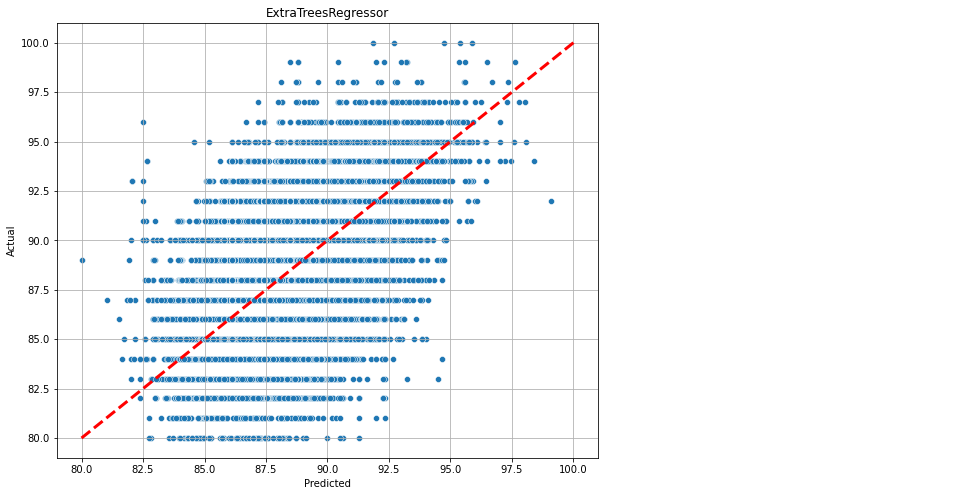

In [124]:
fig, ax = plt.subplots(ncols=2,figsize=(16,8),gridspec_kw=dict(width_ratios=[2,1]))
sns.scatterplot(ax=ax[0],data=result_DF, x="Predicted", y="Actual")
ax[0].plot([80, 100], [80, 100], 'r--', lw=3)
ax[0].grid(True)
ax[1].axis("off")
ax[0].set_title("ExtraTreesRegressor")
plt.show()